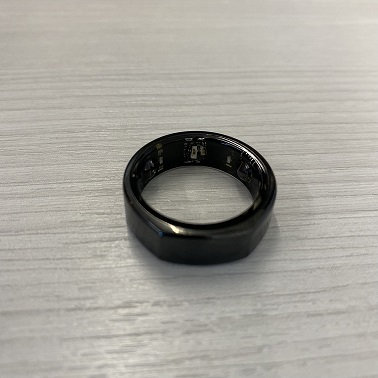

_A picture of the Oura Ring 3 that was used for this notebook_

At **\$299** + **\$5.99** per month and a weight of just 4-6 grams, the [Oura Ring 3](https://support.ouraring.com/hc/en-us/articles/4409072131091-Meet-Gen3) is a unique Sleep and physical activity tracker that, beyond having a price-to-weight ratio higher than gold, has achieved much attention for its ease of use in clinical studies and comfortable wear.

We have used the Oura ring for a month, and we will show you how to extract its data, visualize sleep stages for time and compute correlations and statistical significance from sleep scores to step counts.

This is a comprehensive, clear guide to extract our data from the Oura Ring 3 using the Oura API. Links to external resources and official Oura documentation are provided sporadically throughout the guide for further reference.

If you want to learn more about the Oura ring, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/oura_ring_3) for a detailed analysis of performance, sensors, data privacy, and extraction pipelines.
<br></br>

A list of the most important accessible data categories is provided below, For the full list, access the meta_api_data in section 3.2. There are two versions of the API: versions 1 and 2, so (V1) and (V2) in the parameter list refer to the API version. Version 2 of the API is the more recent version that's still being updated and will replace version 1, and that's why both are included here.
**The items in bold are the ones we use in the notebook.**

Category Name (API version)| Parameter Name (subcategory)| Frequency of Sampling 
:-------------------:|:----------------------:|:----------------------:
**Heart rate (V2)** | **BPM** | **Every 5 mins**
**Daily activity (V2)** | **resting time**|**Daily**
Daily activity (V2) | active calories|Daily 
**Daily activity (V2)** | **equivalent walking distance**|**Daily** 
Daily activity (V2) | steps |Daily
Daily activity (V2) | medium activity time |Daily
Daily activity (V2) | total calories |Daily
Daily activity (V2) | low activity time |Daily
Daily activity (V2) | non-wear time |Daily
Daily activity (V2) | overall score |Daily
Sleep (V1) | awake time |Daily
Sleep (V1) | average breath rate |Daily
**Sleep (V1)** | **REM sleep time** |**Daily**
**Sleep (V1)** | **deep sleep time** |**Daily**
**Sleep (V1)** | **light sleep time** |**Daily**
**Sleep (V1)** | **temperature deviation** |**Daily**
Sleep (V1) | bedtime start |Daily
Sleep (V1)| restless time |Daily
Sleep (V1)| duration |Daily
Activity (V1) | score of recovery time |Daily
Activity (V1) | overall Score|Daily
Activity (V1) | high activity time|Daily
Activity (V1) | low activity time|Daily
Activity (V1) | total activity time|Daily
Activity (V1) | inactive time|Daily
Activity (V1) | target miles|Daily
Activity (V1) | target Calories|Daily
Activity (V1) | training frequency score|Daily
Readiness (V1) | activity balance score |Daily
**Readiness (V1)** | **previous day score**|**Daily**
**Readiness (V1)** | **previous night score** |**Daily**
Readiness (V1) | sleep balance score|Daily
Readiness (V1) | temperature score|Daily 
Ideal bedtimes (V1) | bedtime window|Daily
Sleep (V1) | bedtime end|Daily
**Sleep (V1)** | **Overall score**|**Daily**
Sleep (V1) | efficiency|Daily
<br></br>






In this guide, we sequentially cover the following **five** topics to extract data from the Oura Ring API:

1. **Setup**
    - 1.1: Study participant setup and usage
    - 1.2: Library imports needed to follow through
2. **Authentication/Authorization**
    - 2.1: OAuth(2), allowing access for multiple entities
    - 2.2: Personal access token, intended for personal use 
3. **Data extraction**
    - 3.1: Setting up the parameters to extract the data.
    - 3.2: Extracting data from version 2 endpoints
    - 3.3: Extracting data from version 1 endpoints
    - 3.4: Aggregating the data to be able to easily access it
    - 3.5: Plotting multiple parameters simultaneously
4. **Data visualization**
    - 4.1: Visualizing the different sleep stages 
    - 4.2: Visualizing Resting Heart Rate
    - 4.2: Visualizing Body temperature
5. **Data analysis**
    - 5.1: Finding Outliers (Anomaly Detection). We provide two ways to find outliers in any set of output data.
    - 5.2: Dispersion analysis between day and night readiness scores.
    - 5.3: We try to find a correlation between equivalent walking distance and the amount of deep sleep. We then find that the correlation is not statistically significant. 
    - 5.4: We try to find a correlation between resting time and sleep score. We then find that this correlation is statically significant.

*Note: Full documentation of APIs by Oura can be found [here](https://cloud.ouraring.com/v2/docs) (version 2) and [here](https://cloud.ouraring.com/docs/) (version 1).

# 1. Setup

## 1.1 Study participant setup and usage


## Participant Setup

Dear Participant,

First, download the Oura app from the app store and charge the ring. When the LED blinks blue, the ring is ready to pair. Pair the phone to the ring with Bluetooth and follow the instructions in the app to create your Oura account. You have to spend one night wearing the ring for sleep and readiness score to appear, but the rest of the data will be available immediately. Check [this](https://support.ouraring.com/hc/en-us/articles/4411128662291-Set-Up-an-Oura-Ring) out if you need more info about the setup.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create an Oura account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.


To make data available for extraction, you will just need the username and password to generate the API key as illustrated in section 2. Once an API key is generated, these would be no need for the log-in information on the researcher's side. 

## 1.2 Library imports

In [ ]:
# Uncomment and Run the following command to install the nessecary libraries locally
# pip install requests matplotlib numpy scipy seaborn pandas

# Relevant libraries are imported below.
import requests
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib.patches import FancyBboxPatch

# 2. Authentication/Authorization

To obtain access to data, authentication is required. There are two ways to authenticate, namely:
* [OAuth 2.0](https://cloud.ouraring.com/oauth/applications)


* [Personal Access Token](https://cloud.ouraring.com/personal-access-tokens)

OAuth 2.0 is considered the gold standard. While certainly not [foolproof](https://datatracker.ietf.org/doc/html/draft-ietf-oauth-security-topics), it offers one of the most comprehensive and easily accessible security measures. More information about the OAuth 2.0 protocol is available [here](https://datatracker.ietf.org/doc/html/rfc6749).

Alternatively, Oura also allows for data extraction through Personal Access Tokens (PAT). As a much less secure method, Oura recommends use of PATs for personal use only.

**Clinical use == OAuth 2.0**

*Note: You have to login fist to be able to authenticate

## 2.1 OAuth 2.0

OAuth 2.0 can be created by visiting this [link](https://cloud.ouraring.com/oauth/applications) and registering a new application. A couple things to take note of:
* `client_id`: A unique ID required to obtain a code or access token
* `client_secret`: A secret code for added security
* Redirect URIs: `https://127.0.0.1:8080` is also known as the localhost and is where a user can receive a code or token
* Allow server-side authentication/Allow client-side authentication: Allows the user to obtain a code or token

Server-side authorization is more secure but only returns a code, which should then be traded again for a token. Client-side authorization is less secure, but allows users to skip the step of trading the code for a token. For beginners, we recommend utilizing client-side authentication for simplicity.

This is shown below

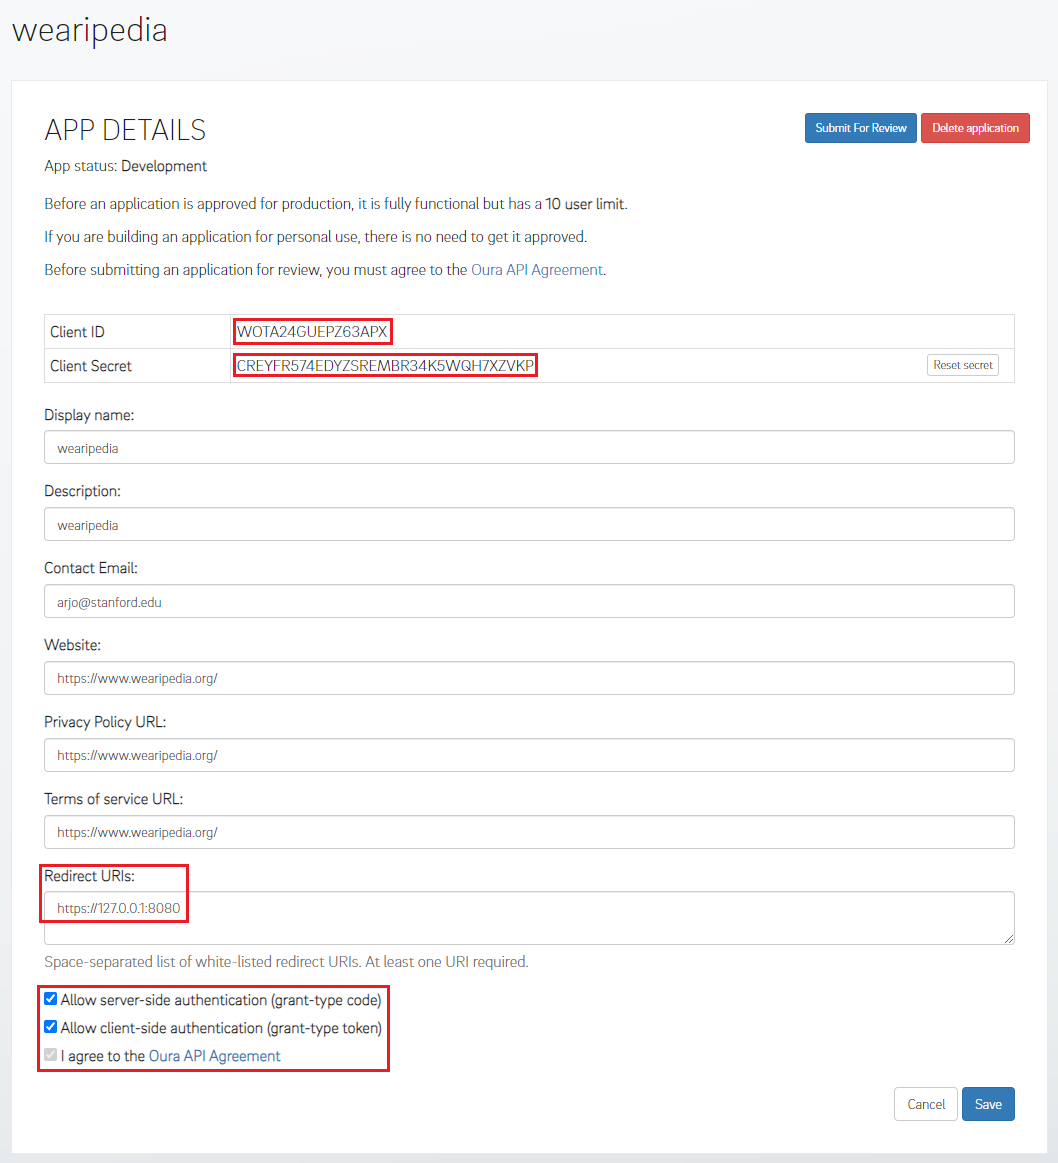



In [ ]:
# We will start storing pertinent parameters into a Python dictionary (`variables`)
variables = dict()

# CHANGE THESE PARAMETERS WITH YOUR OWN ID AND SECRET
variables["client_id"] = "WOTA24GUEPZ63APX"
variables["client_secret"] = "CREYFR574EDYZSREMBR34K5WQH7XZVKP"

# DO NOT CHANGE THESE PARAMETERS
variables["state"] = "XXXX"
variables["redirect_uri"] = "https%3A%2F%2F127.0.0.1%3A8080"
variables["response_type"] = "token"

Afterwards, generate a link with the following code block. Alternatively, a link is provided underneath the APP DETAILS page.

This is shown below

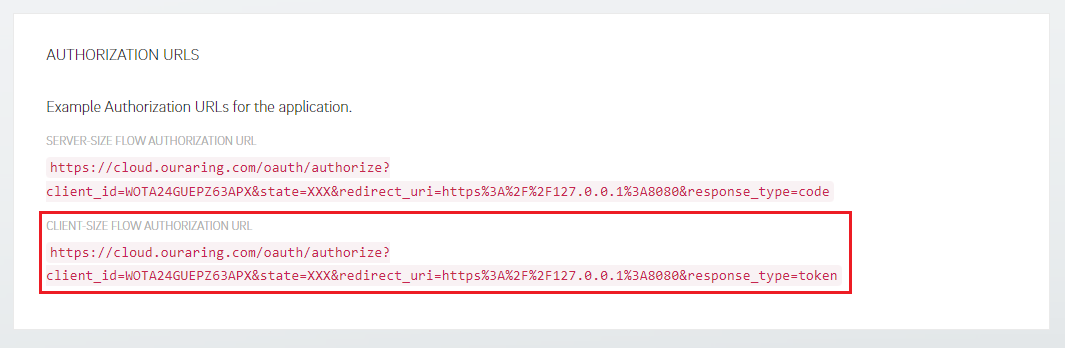

In [ ]:
url = "https://cloud.ouraring.com/oauth/authorize"
for key, value in variables.items():
    if url == "https://cloud.ouraring.com/oauth/authorize":
        url += "?" + key + "=" + value
    elif key == "client_secret":
        # exclude client_secret in url for token
        continue
    else:
        url += "&" + key + "=" + value

print(url)

https://cloud.ouraring.com/oauth/authorize?client_id=WOTA24GUEPZ63APX&state=XXXX&redirect_uri=https%3A%2F%2F127.0.0.1%3A8080&response_type=token


Click on the resulting link above, and click accept. Afterwards, make sure to copy the URL as it provides the access token required to extract data.

This is shown below

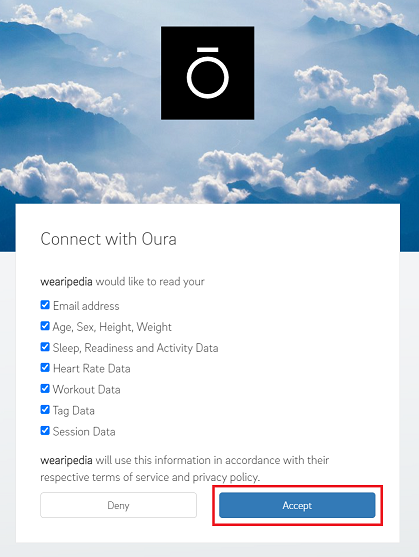

[link text](https://127.0.0.1:8080/#access_token=ZEGOXLJXB6STEBBMQLRZBKYFGM2HPTOO&token_type=bearer&expires_in=2592000&scope=email%20personal%20daily%20heartrate%20workout%20tag%20session&state=XXX) From this URL, take the combination of letters and numbers after `access_token=` until `&token_type=`. This constitutes the `access_token` required to extract data for this user.

> https://127.0.0.1:8080/#access_token=NZA3DRAHG37X2GDV34YV4Q7XETOKSXKE&token_type=bearer&expires_in=2592000&scope=email%20personal%20daily%20heartrate%20workout%20tag%20session&state=XXXX

In this case, the `access_token` is **NZA3DRAHG37X2GDV34YV4Q7XETOKSXKE**. This is added to the `variables` Python dictionary in the code below (hereafter known as `oauth_access_token`).

*Note: This access token will expire in 2592000 seconds, which is one month. If the `oauth_access_token` no longer works due to expiry, please obtain a new `oauth_access_token`.

In [ ]:
variables["oauth_access_token"] = "NZA3DRAHG37X2GDV34YV4Q7XETOKSXKE"

## 2.2 Personal Access Token


A personal access token (PAT) is an easy and simple alternative to OAuth 2.0. PATs can be created [here](https://cloud.ouraring.com/personal-access-tokens) and revoked at anytime if tokens are compromised. PATs are visible only at creation and are otherwise hidden from view, save for the first five characters. For privacy reasons, PATs are typically only meant for personal use, and experiments where one entity requires access to multiple entities' data should utilize OAuth 2.0.

This is shown below

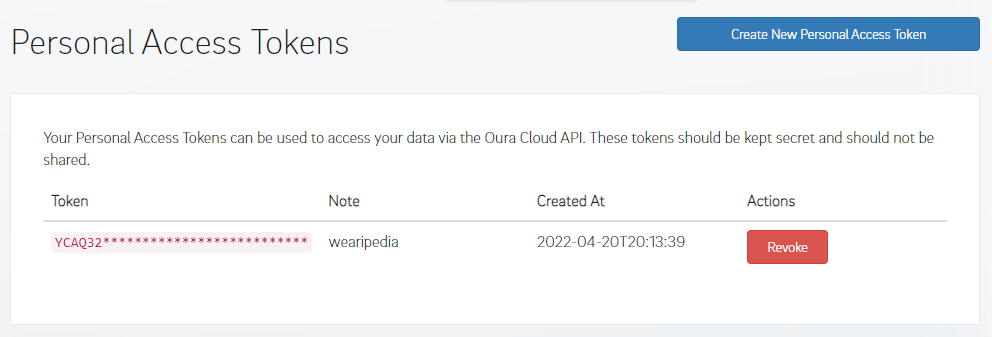

The `personal_access_token` similarly requires `"Bearer "` in front of the token.

In [ ]:
variables["personal_access_token"] = "SZTX3OON6SAX7GOOOWQX5SK2GGZGBDVG"

# 3. Data extraction
***Note: Documentation, data availability, and function arguments (most likely endpoints) are subject to change.**

Data can be extracted using the Oura Ring API. There are currently two versions (VERSION 2 and VERSION 1) of which VERSION 1 is most likely soon to be deprecated. VERSION 2 is the newer version and has more detailed documentation. Oura allows users to access data from the categories in section 3.2.

Some data categories are still available through VERSION 1 endpoints for at least one year after the resealse of V2 in Jan-2022 [according to Oura](https://cloud.ouraring.com/v2/docs#tag/Daily-Sleep).

In the following sections, VERSION 2 will precede VERSION 1 as it is more up-to-date.



## 3.1 Set Up The Parameters



First, we select the start and end dates that we want to extract data from. We can use either `personal_access_token` or `oauth_access_token` depending on which one used in the athentication.

In [ ]:
#@title You can change these parameters
START_DATE = "2022-03-20" #@param {type:"string"}
END_DATE = "2022-04-01" #@param {type:"string"}

# change key to "personal_access_token" if using PAT
TOKEN_TYPE = "personal_access_token" #@param {type:"string"}
ACCESS_TOKEN = variables[TOKEN_TYPE] 

## 3.2 VERSION 2 Endpoints

These data categories are available through VERSION 2 endpoints as of 21 April 2022.

* [Personal Info](https://cloud.ouraring.com/docs/personal-info)
* [Heart Rate](https://cloud.ouraring.com/v2/docs#tag/Heart-Rate)
* [Sessions](https://cloud.ouraring.com/v2/docs#tag/Sessions)
* [Tags](https://cloud.ouraring.com/v2/docs#tag/Tags)
* [Workouts](https://cloud.ouraring.com/v2/docs#tag/Workouts)

We write a function which takes the following parameters:
*   `start_date`: Starting date
*   `end_date`: Ending date
*   `access_token`: Access token
The following parameters may vary depending on the type of data we access. They are specified below and should be left alone.

*   STATIC `endpoint`: URL to extract data from
*   STATIC `start_date_col`: Column name for start date
*   STATIC `end_date_col`: Column name for end date
*   STATIC `call`: Type of [CRUD](https://www.codecademy.com/article/what-is-crud) call in [HTTP](https://www.w3schools.com/whatis/whatis_http.asp), defaults to "GET"

In [ ]:
# function that executes a GET request on the API (for version 2 endpoints)
def call_API_version_2(
    url: str,
    start_date = START_DATE, 
    end_date = END_DATE,
    access_token = ACCESS_TOKEN,
    start_date_col: str = "start_date",
    end_date_col: str = "end_date",
    call: str = "GET"
):
    headers = { "Authorization": "Bearer " + access_token }
    params = { start_date_col: start_date, end_date_col: end_date }
    return requests.request(
        call, url=url, headers=headers, params=params).json()

In [ ]:
# Next, we call all the data from each corresponding URL.


# heart_rate
heart_rate = call_API_version_2(
    url="https://api.ouraring.com/v2/usercollection/heartrate",
    start_date_col="start_datetime",
    end_date_col="end_datetime",
    start_date=START_DATE + "T00:00:00-23:59",
    end_date=END_DATE + "T00:00:00-23:59"
)

# personal_info
personal_info = call_API_version_2(url="https://api.ouraring.com/v2/usercollection/personal_info")

# sessions
sessions = call_API_version_2(url="https://api.ouraring.com/v2/usercollection/sessions")

# tag
tag = call_API_version_2(url="https://api.ouraring.com/v2/usercollection/tag")

# workout
workout = call_API_version_2(url="https://api.ouraring.com/v2/usercollection/workout")

# daily_activity
daily_activity = call_API_version_2(url="https://api.ouraring.com/v2/usercollection/daily_activity")


## 3.3 VERSION 1 Endpoints

These data categories are available through VERSION 1 endpoints as of 25 April 2022.

* [Daily Sleep](https://cloud.ouraring.com/docs/sleep)
* [Daily Activity](https://cloud.ouraring.com/docs/activity)
* [Daily Readiness](https://cloud.ouraring.com/docs/readiness)
* [Ideal Bedtime](https://cloud.ouraring.com/docs/bedtime)

The VERSION 1 function similarly takes the following parameters:
*   `start_date`: Starting date
*   `end_date`: Ending date
*   `access_token`: Access token (either `personal_access_token` or `oauth_access_token`)

The remaining parameters are similarly specified and should be left alone.

In [ ]:
# function that executes a GET request on the API (for version 1 endpoints)
def call_API_version_1(
    url: str,
    start_date = START_DATE,
    end_date = END_DATE,
    access_token = ACCESS_TOKEN,
    start_date_col: str = "start",
    end_date_col: str = "end",
    call: str = "GET"
):
    params = {
        "access_token": access_token,
        start_date_col: start_date,
        end_date_col: end_date
    }
    return requests.request(
        call, url=url, params=params).json()

In [ ]:
# sleep
sleep = call_API_version_1(url="https://api.ouraring.com/v1/sleep")

# activity
activity = call_API_version_1(url="https://api.ouraring.com/v1/activity")

# readiness
readiness = call_API_version_1(url="https://api.ouraring.com/v1/readiness")

# ideal_bedtimes
ideal_bedtimes = call_API_version_1(url="https://api.ouraring.com/v1/bedtime")

## 3.4 Data Aggregation

After this point, there are two variables to take note of.
* `api_data` - a [dictionary](https://docs.python.org/3/library/stdtypes.html#mapping-types-dict) type which contain all extracted data as a [list](https://docs.python.org/3/library/stdtypes.html#sequence-types-list-tuple-range) of dictionaries
* `meta_api_data` - a dictionary type which contains the keys of all extracted data as dictionaries

To access information from these dictionaries, call the keys or values functions on either variable. Simply printing may suffice as well (but may be way too long to visualize properly). Examples and some code is listed below to better visualize the data.
  
---
  
api_data
* `api_data.keys()`
* `api_data.values()`
* `print(api_data)`

meta_api_data
* `meta_api_data.keys()`
* `meta_api_data.values()`
* `print(meta_api_data)`

In [ ]:
# aggregate data for version 2 endpoints
api_data = dict()
api_data["personal_info"] = [personal_info]
# api_data["heart_rate"] = heart_rate["data"]
print(heart_rate)
api_data["sessions"] = sessions["detail"] if sessions["detail"] != "Not Found" else [{}]
api_data["tag"] = tag["data"] if tag["data"] else [{}]
api_data["workout"] = workout["data"] if workout["data"] else [{}]
api_data["daily_activity"] = daily_activity["data"] if daily_activity["data"] else [{}]

{'message': 'Subscription not valid'}


KeyError: ignored

In [ ]:
# aggregate data for version 1 (in addition to VERSION 2)
api_data["sleep"] = sleep["sleep"]
api_data["activity"] = activity["activity"]
api_data["readiness"] = readiness["readiness"]
api_data["ideal_bedtimes"] = ideal_bedtimes["ideal_bedtimes"]

In [ ]:
# initalize metadata with information for all api_data value keys
meta_api_data = {i:{j for j in api_data[i][0].keys()} for i in api_data.keys()}

In [ ]:
# print api_data
for key, value in api_data.items():
    print(key, ":", value)

In [ ]:
# print meta_api_data
for key, value in meta_api_data.items():
    print(key, value)

# 4. Data visualization

## 4.1 Sleep Stages Visualization

When using the Oura app, the user has access to their sleep history as a plot under the sleep tab. The stages of sleep are delineated and the amount of time under each sleep stage can be visualized on a daily basis (shown below).
<br></br>
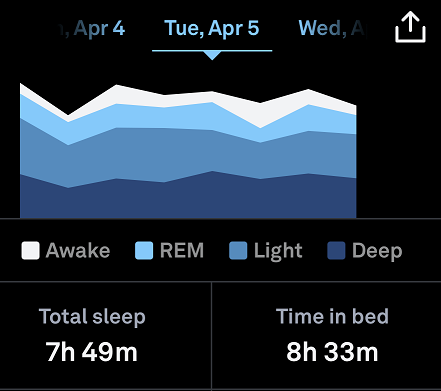
<br></br>
In the above plot, we've recreated a plot using `matplotlib` and extracting sleep parameters from the Oura device.

Oura stacks different sleep stages on top of one-another. From the bottom, the plot shows **Deep Sleep**, followed by **Light Sleep**, **REM Sleep**, and **Time Awake**. When stacked on top of one another, it gives a visual overview of the sleep quality and time spent slept (Deep + Light + REM).

To create the plot, first, we extract our data of interest, the amount of deep sleep, light sleep, rem sleep, awake time, and the dates from api_data dictionary into separate arrays. Then we will use `matplotlib`'s `pyplots` library on [stackplot](https://matplotlib.org/stable/gallery/lines_bars_and_markers/stackplot_demo.html#sphx-glr-gallery-lines-bars-and-markers-stackplot-demo-py). The stackplot allows us to represent the different sleep stages, including the awake state, stacked on top of each other. After this, we adjust the aesthetic components of the plot to make it look like the original.

In [ ]:
"""
1. Extract the parameters of interest from our api call
    - api_data is a list of daily logs
    - looping over api_data will store daily sleep parameters in separate lists
"""
deep, light, rem, awake, dates = [], [], [], [], []
for elem in api_data['sleep']:
    deep.append(elem['deep'] / 60 / 60)  # sec -> min -> hour
    light.append(elem['light'] / 60 / 60)
    rem.append(elem['rem'] / 60 / 60)
    awake.append(elem['awake'] / 60 / 60)
    dates.append(elem['summary_date'])
api_data['sleep'][0]['summary_date']

# put data into a dictionary for the stackplot function below
sleepData ={
    'Deep': deep,
    'Light': light,
    'REM': rem,
    'Awake': awake
}
start_date = dates[0]
end_date = dates[-1]

"""
2. Plot stackplot with matplotlib
"""
# set style to dark
plt.style.use('dark_background')

# define colors for Deep, Light, REM, Awake
color_map = ["#2c4677", "#568bbd", "#85c9fa", "#f2f3f5"]

# setup and plot
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
plt.rc('font', size=22)
ax.stackplot(dates, sleepData.values(),
             labels=sleepData.keys(), colors=color_map, alpha=0.8)

# removing the borders from four sides
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


#remove x and y tics
plt.xticks([])
plt.yticks([])

#set a new order for handles and lables
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]

# set legend below plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(0.5, 0.26),
          fancybox=True, shadow=True, ncol=5, fontsize= 18, frameon=False, handlelength=0.9)
ax.set_title('Thurs, March 24', color = '#85c9fa')

#getting total sleep and time in bed for march 24th
for metric in api_data["sleep"]:
    if metric['summary_date'] == '2022-03-24':
        total_in_bed = metric['total']
        restless = metric['restless']
        total_sleep = total_in_bed - restless

#get hours and minutes separated
totalinbed_h = total_in_bed // 60 // 60  #convert to hours
totalinbed_m = (total_in_bed // 60) - (totalinbed_h * 60) #see how many mins left

totalsleep_h = total_sleep // 60 // 60
totalsleep_m = (total_sleep // 60) - (totalsleep_h * 60)

# updated strings
inbed_h_m = str(totalinbed_h) + "h "+ str(totalinbed_m) + 'm'
sleep_h_m = str(totalsleep_h) + "h "+ str(totalsleep_m) + 'm'

#adding the total sleep and time in bed
plt.figtext(0.3,0,'Total sleep', fontsize=18, ha='center', color ='#959caa', fontweight = 'bold')
plt.figtext(0.72,0,'Time in bed', fontsize=18, ha='center', color ='#959caa', fontweight = 'bold')
plt.figtext(0.3,-0.15,sleep_h_m, fontsize=24, ha='center', color ='w', fontweight = 'bold')
plt.figtext(0.72,-0.15,inbed_h_m, fontsize=24, ha='center', color ='w', fontweight = 'bold')

#create the horizontal lines for the legend
line = plt.Line2D((-1, 9), (-0.1, -0.1), lw=1.3)
line2 = plt.Line2D((-1, 9), (-3, -3), lw=1.3)
plt.gca().add_line(line)
plt.gca().add_line(line2)

#creating the vertical line using a different and definetly not a neat
#way since using the same way alters the whole plot
i = 0.13
while i > -0.27:
    plt.figtext(0.5,i,'|', fontsize=10, ha='center', color ='w')
    i -= 0.01

plt.show()

## 4.2 Visualizing Resting Heart Rate 

Next, we will try can recreate the resting heart rate plot found in the Oura Ring app. The heart rate measured during sleep is visualized and represented in the plot. First, we gather the wake and sleep times and format them. Then, we collect the heart rates and the times at which they were recorded from the api_data dictionary. After this, we plot the graph and edit its aesthetic aspects. Finally, we place labels at the top of the sleep time and the waking up time.

Here is the visual we are trying to replicate from the app.

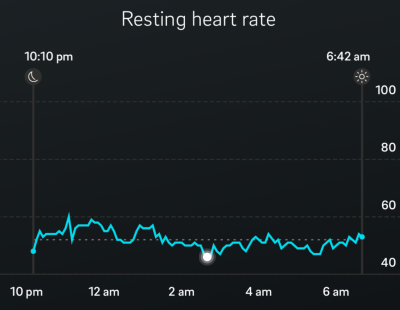

In [ ]:
the_date = "2022-03-23" #@param {type:"date"}

#protecting againist dates with no data
try:
    
  # first we get the bed time and waking up time from the sleep data
  for metric in api_data["sleep"]:
      if metric['summary_date'] == the_date:
          start_time = metric['bedtime_start'][11:19].replace(":","")
          start_in_hours = float((start_time)[:2]) + float((start_time)[2:4]) / 60 + float((start_time)[4:6]) / 3600

          end_time = metric['bedtime_end'][11:19].replace(":","")
          end_in_hours = float((end_time)[:2]) + float((end_time)[2:4]) / 60 + float((end_time)[4:6]) / 3600
          break


  with plt.style.context('dark_background'):

  # getting the bpm and the time stamp of the given date        
      bpm, timestamp = [], []
      for elem in api_data['heart_rate']:
          # Here we get the date from the timestamp
          date_temp = elem['timestamp'][0:10]  
              
          # checking for entries with the desired date
          if date_temp == the_date:
              # getting times from timestamp
              time_temp = elem['timestamp'][11:19]
              time_string = time_temp.replace(":","")
              # converting the times to hours
              time_hours = float((time_string)[:2]) + float((time_string)[2:4]) / 60 + float((time_string)[4:6]) / 3600
              timestamp.append(time_hours)
              bpm.append(elem['bpm'])
      # smoothing the data for visulaization
      filtered_data = gaussian_filter(timestamp, sigma=3)

      # creating the plot and setting the background color
      fig = plt.figure(figsize=(6.5,4))
      fig.patch.set_facecolor('#171b1e')

      #getting the average bpm
      av = sum(bpm)/len(bpm)
      #creating an average line 
      plt.axhline(y=av, dashes = (2,5), linewidth = 1)

      plt.plot(filtered_data, bpm, linewidth=3, color='#07c8d8')


      # setting the x labels
      times = [22,2,6,10,14,18,22]
      plt.xticks(ticks=times, labels=['10 PM', '2 AM', '6 AM', '10 AM', '2 PM', '6 PM','10 PM'])
      
      #setting the minor tics as the sleep time and the wake up time
      start_and_end = [start_in_hours, end_in_hours]
      plt.gca().set_xticks(ticks = start_and_end, minor=True)

      # adjusting the label size
      plt.tick_params(axis='x', labelsize=12)
      plt.tick_params(axis='y', labelsize=12)

      # removing the borders from four sides
      plt.gca().spines['left'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)

      # change the y-labels to the right side 
      plt.gca().yaxis.tick_right()

      #remove the tic dashes
      plt.gca().yaxis.set_tick_params(length=0,labelbottom=False)

      # set the colors of the grid
      plt.gca().grid(axis='y', color='#383838', dashes = (8,5))
      plt.gca().grid(axis='x', which = "major", visible = False)
      plt.gca().grid(axis='x', which = "minor", color = '#383838')

      # place a title on the graph
      plt.figtext(0.52,1,'Resting heart rate', fontsize=18, ha='center', color ='w', fontweight=0)
      
      # adjust the facecolor
      plt.gca().set_facecolor('#171b1e')

      #increase the limits of the yaxis
      plt.ylim(top=200)
      plt.ylim(bottom=40)

      #keeping on only some of the y values by adjusting the labels
      bpms = [60, 100, 140, 180]
      plt.yticks(ticks=bpms, labels=['60', '100', '140','180'])
      
      #placing the labels on the vertical bars
      #first convert to the hours and minutes format
      start_hours = int(start_in_hours) 
      start_mins = int((start_in_hours - start_hours) * 60)  
      end_hours = int(end_in_hours)
      end_mins = int((end_in_hours - end_hours) * 60)  

      #formating the minutes
      if start_mins < 10:
          start_mins = '0'+ str(start_mins)  
      else:
          start_mins = str(start_mins)
      
      if end_mins < 10:
          end_mins = '0'+ str(end_mins)  
      else:
          end_mins = str(end_mins)

      #convert to 12_hour system and prepare the labels
      if start_hours == 0:
          startlabel = "12" + ":" + (start_mins) + " am"
      elif start_hours < 12:
          startlabel = str(start_hours) + ":" + (start_mins) + " am"
      elif start_hours == 12:
          startlabel = "12" + ":" + (start_mins) + " pm"
      else:
          startlabel = str(start_hours-12) + ":" + (start_mins) + " pm"

      if end_hours == 0:
          endlabel = "12" + ":" + (end_mins) + " am"
      elif end_hours < 12:
          endlabel = str(end_hours) + ":" + (end_mins) + " am"
      elif end_hours == 12:
          endlabel = "12" + ":" + (end_mins) + " pm"
      else:
          endlabel = str(end_hours-12) + ":" + (end_mins) + " pm"



      #notice that the graph spans from 0.15 to 0.9 which makes
      #the range equal to 0.75 so we place the label in its
      #right location relative to this range
      plt.figtext(0.15+((start_in_hours/24)*0.75), 0.9,startlabel, fontsize=11, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.15+((end_in_hours/24)*0.75), 0.9,endlabel, fontsize=11, ha='center', color ='w', fontweight = 'bold')

      plt.show(block=True)
except:
  print('No data at this date')

It looks like we were able to replicate the main elements of the plot with matplotlib!

## 4.3 Visualizing Body temperature  

Here is another visualization from the Oura app that we will try to replicate.
To create this plot, first we extract the temperature_delta data and the dates from the the api_data dictionary and save them in separate arrays. After this we create a bar graph, adjust the aesthetic elements to make it look like the original. We finally make the bars have rounded corners, and voila!


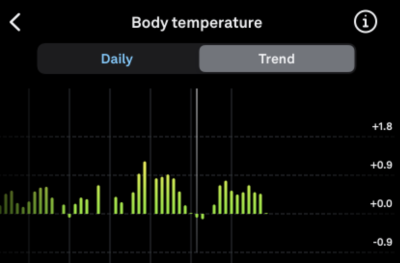

In [ ]:
with plt.style.context('dark_background'):
        
    temperature_delta, summary_date = [], []

    for elem in api_data['sleep']:
        temperature_delta.append(elem["temperature_delta"])
        summary_date.append(elem['summary_date'])
    

    fig,ax = plt.subplots()
    
    fig.set_size_inches(6, 6)


    # bar graph
    plt.bar(summary_date, temperature_delta, color = '#96c146', width = 0.3)

    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    #removing the borders
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    #make the y tics on the right
    plt.gca().yaxis.tick_right()
    
    #change the colors of the grid
    plt.gca().grid(axis='y', color='#1d2021', dashes = (8,5))
    plt.gca().grid(axis='x', color='#1d2021')
  

    #remove the tic dashes
    ax.yaxis.set_tick_params(length=0,labelbottom=False)

    #put a title 
    plt.title("Body Temperature", fontsize=15,fontweight = 'bold')
    
    # making the graph roundish like. from https://stackoverflow.com/questions/58425392/bar-chart-with-rounded-corners-in-matplotlib
    new_patches = []
    for patch in reversed(ax.patches):
        bb = patch.get_bbox()
        color=patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin/4, bb.ymin),
                            abs(bb.width)/2, abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=0.015",
                            ec="none", fc=color)
        patch.remove()
        new_patches.append(p_bbox)
    for patch in new_patches:
        ax.add_patch(patch)
        
    #remove x tics
    plt.xticks([])

    #increase the limits of the yaxis
    plt.ylim(top=0.6)
    plt.ylim(bottom=-0.6)

    plt.show(block=True)
    

##4.4 Visualizing Non-Wear Time

Although this can't be shown in the Oura app, we are going to see how much time was the Oura Ring wasn't worn here. First, we gather the non-wear time and dates and place them in separate arrays. Then we create a simple bar plot and make it visually appealing using seaborn library. 

In [ ]:
arr1 = []
arr2 = []
for metric in api_data["activity"]:
    arr1.append(metric['summary_date'])
for metric in api_data["activity"]:
    arr2.append(metric['non_wear'])

d = {'Non Wear Time (mins)': arr2, 'Date': arr1}
df = pd.DataFrame(data=d)

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Non Wear Time (mins)", y="Date", data=df)

## 4.5 Visualizing Four Parameters In One Plot


Let's overlay medium activity time, REM sleep time, resting time, and non-wear time, all in one plot and investigate the trends among them. It is possible because they are all represented the amount of time spended in each activity.
We represent each parameter with a different graph color that is illustrated in the graph's legend.

In [ ]:


# first we get those arrays for the wanted parameters
arr_medium = []
arr_rem = []
arr_nonwear = []
arr_resting = []
arr_date = []

# Make sure the values plotted correspond to the same days, since sometimes the ring 
# skips certain data of some days, maybe because the user disabled it

hmap = {}
for metric in api_data["sleep"]:
    hmap[metric["summary_date"]] = metric['rem']

for metric in api_data['activity']:
    if metric['summary_date'] in hmap:
        arr_medium.append(metric['medium']//60)
        arr_nonwear.append(metric['non_wear']//60)
        arr_resting.append(metric['rest']//60)
        arr_rem.append(hmap[metric['summary_date']]//60)
        arr_date.append(metric['summary_date'][5:10])

#creating the plots with the legends
plt.xlabel('Day')
plt.ylabel('Time (mins)')
sns.lineplot(x = arr_date, y = arr_medium, color = 'g', legend = 'auto', label = 'Medium Activity Time')
sns.lineplot(x = arr_date, y = arr_rem, color = 'r', legend = 'auto', label = 'Rem Sleep Time')
sns.lineplot(x = arr_date, y = arr_resting, color = 'b', legend = 'auto', label = 'Resting Time')
sns.lineplot(x = arr_date, y = arr_nonwear, color = 'y', legend = 'auto', label = 'Non-wear Time')

#using seaborn library to make the graph look better
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

#resize the figure
#@title You can change the size of the figure if needed
width = 11 #@param {type:"integer"}
height = 8 #@param {type:"integer"}

plt.rcParams["figure.figsize"] = (width,height) #Set (width, height)

#plotting outliers with a different color
plt.show(block=True)


# 5. Data analysis

**(Note that the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.)**

## 5.1 Finding Outliers (Anomaly Detection)


We find outliers and remove them in order to get better analysis accuracy by removing the possibility of measurement errors, but at the same time it can affect the result's accuracy since some outliers are true outliers: outliers that is important in the data itelf. Check [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7485938) out to learn more about the effects of removing outliers.

There are multiple ways of annotating outliers. According to the [National Institute of Standards and Technology's handbook](https://https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm#:~:text=An%20outlier%20is%20an%20observation,what%20will%20be%20considered%20abnormal.). We assume that a "mild outlier" is a datapoint that is higher than or lower than the first quartile or higher than the third quartile by a distance of the interquartile range multiplied by 1.5 points, while "extreme outliers" are ones that distance multipled by 3 points instead.



In [ ]:
def find_Outliers(category_name, sub_Category_Name):
    # create an array with the data
    arr1 = []
    for metric in api_data[category_name]:
        arr1.append(metric[sub_Category_Name])
    
    # add an outlier data for testing (relevant to sleep data)
    arr1.append(9000)
    
    #find interquartile range
    
    quartiles = numpy.quantile(arr1, [0.25,0.75])
    q1, q3 = quartiles[0],quartiles[1]
    interquartile_Range = q3 - q1
    
    #append outliers
    outliers = []
    for item in arr1:
        if item >= q3+(1.5* interquartile_Range) or item <= q1 - (1.5*interquartile_Range):
            outliers.append(item) 
    return outliers

In [ ]:
# testing with the sleep data
list_Of_Outliers = find_Outliers("sleep", "rem")
print(list_Of_Outliers)

An alternative way is to use the Z-scores of the data points. Since z-scores represent how many standard deviations away a given observation is from the mean. For example, a Z-score of 2.5 means that the data point is 2.5 standard deviations from the mean. 

An arbitrary threshold is usually used in order to detect outliers. In this example, I used 2 and -2 as the thresholds, but you can change that. Usually 3,-3 are the standard cut-off. However, these are somewhat arbitrary can be changed. Check chapters 2.2 and 2.3 [here](http://etheses.dur.ac.uk/2432/1/2432_443.pdf) to learn more.

In [ ]:
def find_Outliers(category_name, sub_Category_Name):
    arr1 = []
    for metric in api_data[category_name]:
        arr1.append(metric[sub_Category_Name])
        
    # add an outlier data for testing (relevant to sleep data)
    arr1.append(9000)
    
    #find z-scores
    z_scores_array = stats.zscore(arr1)
    
    #add outliers
    outliers = []
    i = 0

    #@title You can change the size of the figure if needed
    Upper_Threshold = 2 #@param {type:"integer"}
    Lower_Threshold = -2 #@param {type:"integer"}

    for i in range(len(z_scores_array)):
        if z_scores_array[i] >= Upper_Threshold or z_scores_array[i] <= Lower_Threshold: # you can change the threshold here
            outliers.append(arr1[i])
    return outliers

In [ ]:
# testing with the sleep data
list_Of_Outliers = find_Outliers("sleep", "rem")
print(list_Of_Outliers)

Now lets plot the REM data with outlier(s) highlighted in a different color.

In [ ]:
arr1 = []
for metric in api_data["sleep"]:
    arr1.append(metric["rem"])

# add an outlier data for testing (relevant to sleep data)
arr1.append(9000)

#creating an array for day numbers.
arr2 = []
for i in range(len(arr1)):
    arr2.append(i)

#Creating a dataframe with the arrays
d = {'Rem sleep time': arr1, 'Day #': arr2}
df = pd.DataFrame(data=d)

#Detecting the outliers
list_Of_Outliers = find_Outliers("sleep", "rem")

#creting a list of days that correspond to the outlier values in rem sleep
outlier_days = []
for i in range(len(arr2)):
    if arr1[i] in list_Of_Outliers:
        outlier_days.append(arr2[i])

#creating the plot
plt.xlabel('Day #')
plt.ylabel('Rem sleep time')
plt.scatter(x = df['Day #'], y = df['Rem sleep time'], color = 'b')
plt.rcParams["figure.figsize"] = (5,5)
plt.show(block=True)

#rcreating the second plot without highlighting the outlier
plt.xlabel('Day #')
plt.ylabel('Rem sleep time')
plt.scatter(x = df['Day #'], y = df['Rem sleep time'], color = 'b')
plt.rcParams["figure.figsize"] = (5,5)


#plotting outliers with a different color
plt.scatter(x = outlier_days, y = list_Of_Outliers, color='r')
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

plt.show(block=True)


Here appears the injected datapoint in red since it was detected as an outlier

## 5.2 Dispersion analysis between day and night readiness scores

Statistical dispersion is basically a measure of how spread out a set of data points is. It can show how much the data varies accross entries, and it becomes useful in the cases of large datasets where we need to know if the data entry varies more in case A or case B. In this case we are checking whether readiness score has higher dispersion (varies more) during day or at night.

Dispersion has multiple ways of representation. One of them, according to [The National Institute of Statistics and Economic Studies](https://https://www.insee.fr/en/metadonnees/definition/c1366#:~:text=The%20coefficient%20of%20variation%20(CV,generally%20expressed%20as%20a%20percentage.) is the coefficient of variance, also called the relative standard deviation, which is the standard deviation divided by the mean of the set of values.

In [ ]:
# first we prepare the data that we are trying to get dispersion of 
arr_Day = []
for metric in api_data["readiness"]:
    arr_Day.append(metric["score_previous_day"])
    
arr_Night = []
for metric in api_data["readiness"]:
    arr_Night.append(metric["score_previous_night"])

# calculate standard deviation and mean
standard_deviation_day = numpy.std(arr_Day)
standard_deviation_night = numpy.std(arr_Night)
mean_day = numpy.mean(arr_Day)
mean_night = numpy.mean(arr_Night)

# calculate variance coefficient
variability_coefficient_day = standard_deviation_day / mean_day
variability_coefficient_Night = standard_deviation_night / mean_night

if variability_coefficient_day > variability_coefficient_Night:
    print('Day data variability is higher')
else:
    print('Night data variability is higher')

From the output, it's evident that the coefficient of variability of the night readiness score data is higher than that of the day which means that the values are have higher statistical dispersion. Let's visualize this

In [ ]:
#preparing a dataframe to visualize the data
d = {'day score': arr_Day, 'night score': arr_Night}
df = pd.DataFrame(data=d)

# creating a relplot with seaborn library, using the data frame and specifying the x, and y values
graph = sns.relplot(data=df, y="day score", x="night score")

# mapping the graph and showing it
graph.map(plt.scatter, "night score","day score", edgecolor ="w").add_legend()
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

plt.show(block=True)

This is very obvious visually at this small sample; most of the day scores are concentrated at the area between 90 and 95 while night scores vary more, but we are performing this analysis as a case for larger samples where dispersion can't be compared visually.

## 5.3 Correlation between equivalent walking distance and the amount of deep sleep



Let's perform some more analysis on the data trying to find correlations between different data categories that may be statistically significant relationship. The first hypothesis that comes to mind is that exercise throughout the day may somehow have a correlation with the amount of deep sleep the person gets at night. Let's see if this is true.

In [ ]:
# First identify the outliers to remove them
sleep_Outliers = find_Outliers("sleep", "deep")
walking_distance_outliers = find_Outliers("daily_activity", "equivalent_walking_distance")

# Make sure the values plotted correspond to the same days, since sometimes the ring 
# skips certain data of some days, maybe because the user disabled it
hmap = {}
for metric in api_data["daily_activity"]:
    hmap[metric["day"]] = metric["equivalent_walking_distance"]

arr1 = []
arr2 = []
for metric in api_data["sleep"]:
    if metric["summary_date"] in hmap:
        # remove the outliers
        if metric["deep"] not in sleep_Outliers and hmap[metric["summary_date"]] not in walking_distance_outliers:
            arr1.append(metric["deep"]/3600) #converting to hours
            arr2.append(hmap[metric["summary_date"]])

# plot the data 
d = {'deep sleep (hours)': arr1, 'walking distance (steps)': arr2}
df = pd.DataFrame(data=d)

graph = sns.lmplot(data=df, y="deep sleep (hours)", x="walking distance (steps)")

graph.map(plt.scatter, "walking distance (steps)","deep sleep (hours)", edgecolor ="w").add_legend()
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

plt.show(block=True)

We then calculate the p_value, which is the probability a null hypothesis is true, to see if there is a correlation.



In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(arr1,arr2)
print(p_value)

But it appears that it is statistically insignificant since it is >0.05, 
since there is a 75.5% chance this data may have occured by chance. So the original hypothesis is false, but the same methodology can be applied to almost every other data category to check whether there is a statistically significant correlation or not.


## 5.4 Correlation between resting time and sleep score  

Here is a different hyptotheisis that the amount of resting time during the day has a correlation between the sleep overall score which represents its quality.
With a few changes to the code, we can test for this hypothesis.

In [ ]:
# First identify the outliers to remove them
sleep_Outliers = find_Outliers("sleep", "score")
resting_time_outliers = find_Outliers("daily_activity", "resting_time")

# Make sure the values plotted correspond to the same days, since sometimes the ring 
# skips certain data of some days, maybe because the user disabled it
hmap = {}
for metric in api_data["daily_activity"]:
    hmap[metric["day"]] = metric["resting_time"]

arr1 = []
arr2 = []
for metric in api_data["sleep"]:
    if metric["summary_date"] in hmap:
        # remove the outliers
        if metric["score"] not in sleep_Outliers and hmap[metric["summary_date"]] not in resting_time_outliers:
            arr1.append(metric["score"]) 
            arr2.append(hmap[metric["summary_date"]]/3600) #converting to hours

# plot the data
d = {'sleep score': arr1, 'resting time(hours)': arr2}
df = pd.DataFrame(data=d)
graph = sns.lmplot(data=df, y="sleep score", x="resting time(hours)")
graph.map(plt.scatter, "resting time(hours)","sleep score", edgecolor ="w").add_legend()
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

plt.show(block=True)

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(arr1,arr2)
print(p_value)

The P-value is ~0.009 < 0.05 meaning there is only a ~0.9% probability that this data was arbitrary, which implies statistical significance - the amount of resting time during the day actually affects the sleep score (quality) and there is actual statistical significance here!